# Baseline Model Training and Evaluation

This notebook demonstrates:
1. Data loading and preprocessing
2. Central (non-federated) transformer training
3. Scenario generation and evaluation
4. Baseline metrics for comparison with federated learning

**Hardware Requirements:** Optimized for CPU training on 8GB RAM

In [1]:
# Import required libraries
import sys
import os

# Add project paths
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# ML imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Project imports
from data.loaders import MarketDataLoader, SyntheticDataGenerator
from models.transformer import LightweightTransformer, create_small_transformer, create_tiny_transformer
from evaluation.metrics import ScenarioEvaluator

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Setup complete!
PyTorch version: 2.2.2
CUDA available: False


## 1. Data Loading and Preparation

Generating synthetic training data...
Generated 1200 training samples
Generated 500 test samples

Training data summary:
              close      returns   volatility
count  1.200000e+03  1200.000000  1200.000000
mean   9.697694e+05    -0.011922    15.051326
std    1.515955e+07     1.073958     6.879731
min    1.565557e-11    -5.150387     0.190494
25%    2.385186e-06    -0.573779    11.162991
50%    3.196026e-04     0.000811    15.224498
75%    4.094130e-02     0.543108    18.798017
max    4.511693e+08     5.009276    42.745675


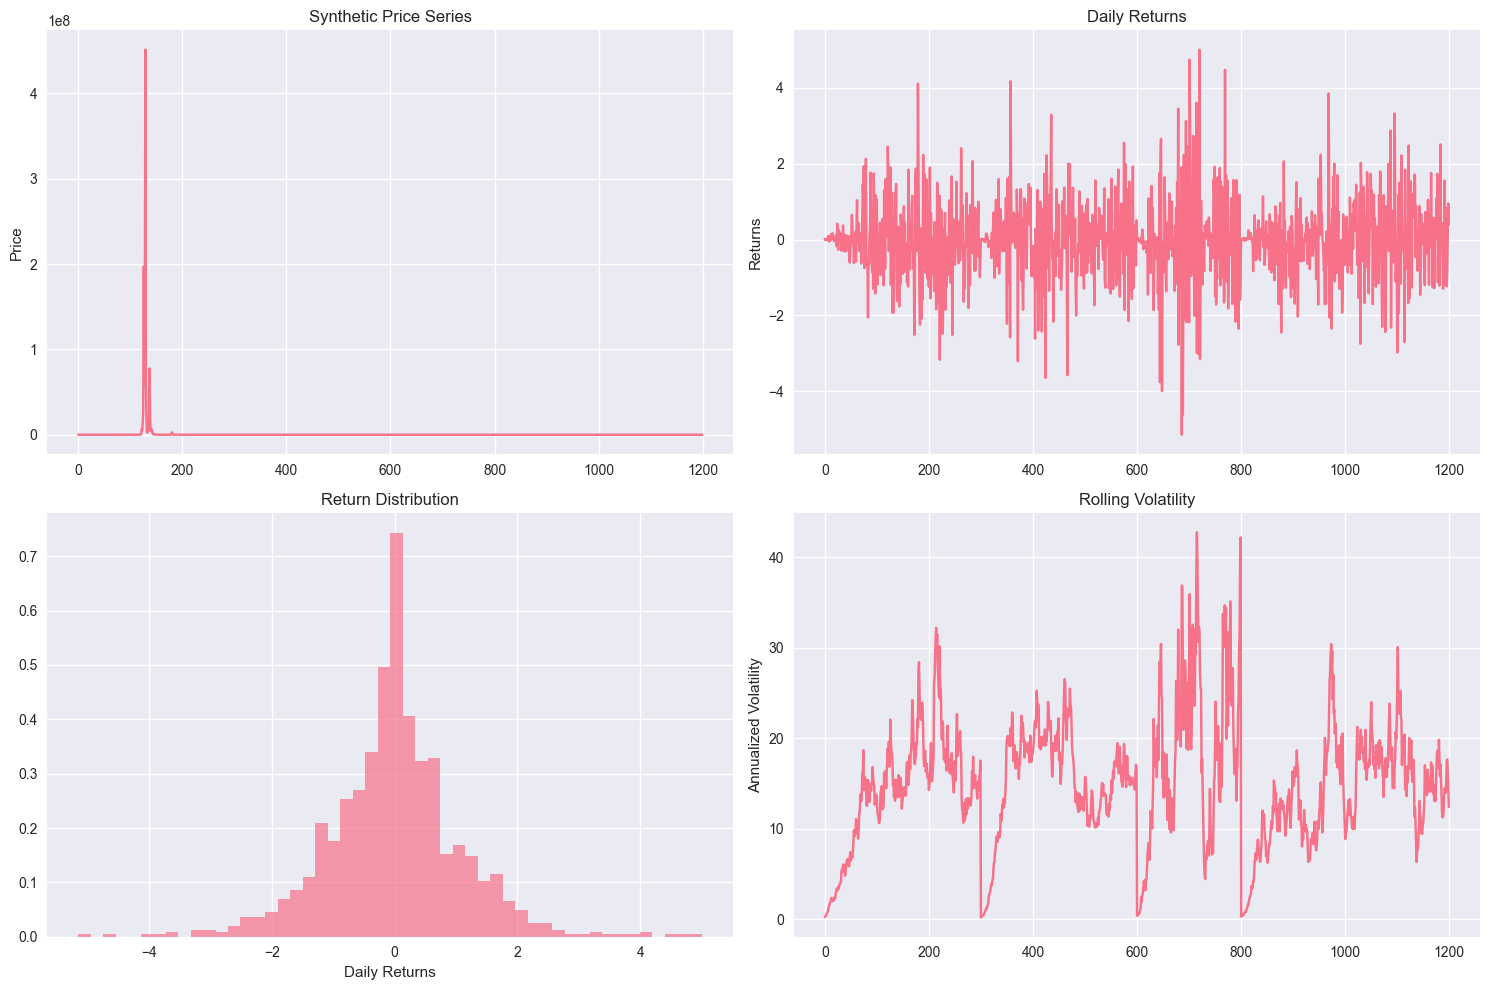

In [2]:
# Initialize data loaders
data_loader = MarketDataLoader()
synthetic_generator = SyntheticDataGenerator(seed=42)

# Create synthetic training data (for demonstration without yfinance dependency)
print("Generating synthetic training data...")

# Generate mixed regime data
regime_lengths = {
    'normal': 800,
    'bull': 300, 
    'volatile': 200,
    'bear': 400,
    'normal': 300
}

train_data = synthetic_generator.create_mixed_regime_data(regime_lengths)
print(f"Generated {len(train_data)} training samples")

# Generate separate test data
test_data = synthetic_generator.generate_regime_data('normal', length=500)
print(f"Generated {len(test_data)} test samples")

# Display data info
print("\nTraining data summary:")
print(train_data[['close', 'returns', 'volatility']].describe())

# Plot the synthetic data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price series
axes[0, 0].plot(train_data.index, train_data['close'])
axes[0, 0].set_title('Synthetic Price Series')
axes[0, 0].set_ylabel('Price')

# Returns
axes[0, 1].plot(train_data.index, train_data['returns'])
axes[0, 1].set_title('Daily Returns')
axes[0, 1].set_ylabel('Returns')

# Return distribution
axes[1, 0].hist(train_data['returns'].dropna(), bins=50, alpha=0.7, density=True)
axes[1, 0].set_title('Return Distribution')
axes[1, 0].set_xlabel('Daily Returns')

# Volatility
axes[1, 1].plot(train_data.index, train_data['volatility'])
axes[1, 1].set_title('Rolling Volatility')
axes[1, 1].set_ylabel('Annualized Volatility')

plt.tight_layout()
plt.show()

## 2. Prepare Training Sequences

In [3]:
# Create training sequences
sequence_length = 64  # Reduced for CPU training
batch_size = 16       # Small batch size for 8GB RAM

# Create sequences from training data
print("Creating training sequences...")
train_sequences, train_targets = data_loader.create_sequences(
    train_data, 
    sequence_length=sequence_length, 
    target_column='log_returns',
    step_size=10  # Skip steps to reduce data size
)

print(f"Created {len(train_sequences)} training sequences")
print(f"Sequence shape: {train_sequences.shape}")
print(f"Target shape: {train_targets.shape}")

# Create test sequences
test_sequences, test_targets = data_loader.create_sequences(
    test_data, 
    sequence_length=sequence_length,
    target_column='log_returns',
    step_size=5
)

print(f"Created {len(test_sequences)} test sequences")

# Convert to PyTorch tensors
train_X = torch.FloatTensor(train_sequences).unsqueeze(-1)  # Add feature dimension
train_y = torch.FloatTensor(train_targets).unsqueeze(-1)
test_X = torch.FloatTensor(test_sequences).unsqueeze(-1)
test_y = torch.FloatTensor(test_targets).unsqueeze(-1)

# Create data loaders
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Creating training sequences...
Created 114 training sequences
Sequence shape: (114, 64)
Target shape: (114,)
Created 88 test sequences
Training batches: 8
Test batches: 6


## 3. Create and Train Baseline Model

In [4]:
# Create a tiny model for CPU training
model = create_tiny_transformer()
print(f"Model parameters: {model.count_parameters():,}")

# Define training configuration
device = torch.device('cpu')  # Force CPU for consistency
model.to(device)

# Optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.MSELoss()

# Training function
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass - predict next value for each position
        output = model(data)  # Shape: (batch_size, seq_len, 1)
        
        # Use last prediction as target
        loss = criterion(output[:, -1, :], target)
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f'  Batch {batch_idx:3d}/{len(train_loader)} | Loss: {loss.item():.6f}')
    
    return total_loss / len(train_loader)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output[:, -1, :], target)
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

print("Starting training...")

Model parameters: 37,777


Starting training...


In [5]:
# Training loop
num_epochs = 20  # Reduced for demo
train_losses = []
test_losses = []
best_test_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 30)
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    
    # Evaluate
    test_loss = evaluate_model(model, test_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(test_loss)
    
    # Record losses
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f"Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")
    
    # Save best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss
        }, '../../data/models/baseline_best_model.pth')
        print(f"  → Best model saved (test loss: {test_loss:.6f})")

print("\nTraining completed!")
print(f"Best test loss: {best_test_loss:.6f}")


Epoch 1/20
------------------------------


  Batch   0/8 | Loss: 1.909577
Train Loss: 1.712729 | Test Loss: 1.165129
  → Best model saved (test loss: 1.165129)

Epoch 2/20
------------------------------
  Batch   0/8 | Loss: 1.015231


Train Loss: 1.746335 | Test Loss: 1.136038
  → Best model saved (test loss: 1.136038)

Epoch 3/20
------------------------------
  Batch   0/8 | Loss: 0.720712


Train Loss: 1.638232 | Test Loss: 1.380501

Epoch 4/20
------------------------------
  Batch   0/8 | Loss: 2.388364
Train Loss: 1.548113 | Test Loss: 1.083277
  → Best model saved (test loss: 1.083277)

Epoch 5/20
------------------------------


  Batch   0/8 | Loss: 1.140020
Train Loss: 1.436513 | Test Loss: 0.947732
  → Best model saved (test loss: 0.947732)

Epoch 6/20
------------------------------
  Batch   0/8 | Loss: 2.495270


Train Loss: 1.226564 | Test Loss: 0.986471

Epoch 7/20
------------------------------
  Batch   0/8 | Loss: 1.987189
Train Loss: 1.416036 | Test Loss: 0.942911
  → Best model saved (test loss: 0.942911)

Epoch 8/20
------------------------------
  Batch   0/8 | Loss: 0.873703


Train Loss: 1.536956 | Test Loss: 0.984981

Epoch 9/20
------------------------------
  Batch   0/8 | Loss: 1.675659
Train Loss: 1.335930 | Test Loss: 0.961897

Epoch 10/20
------------------------------
  Batch   0/8 | Loss: 2.298956


Train Loss: 2.137587 | Test Loss: 0.945298

Epoch 11/20
------------------------------
  Batch   0/8 | Loss: 0.924329
Train Loss: 1.195463 | Test Loss: 0.992832

Epoch 12/20
------------------------------
  Batch   0/8 | Loss: 0.696901


Train Loss: 1.766557 | Test Loss: 0.934194
  → Best model saved (test loss: 0.934194)

Epoch 13/20
------------------------------
  Batch   0/8 | Loss: 1.947058


Train Loss: 1.333632 | Test Loss: 0.916703
  → Best model saved (test loss: 0.916703)

Epoch 14/20
------------------------------
  Batch   0/8 | Loss: 1.201775
Train Loss: 1.360147 | Test Loss: 0.946452

Epoch 15/20
------------------------------


  Batch   0/8 | Loss: 1.038364
Train Loss: 1.289134 | Test Loss: 1.027920

Epoch 16/20
------------------------------
  Batch   0/8 | Loss: 0.648811


Train Loss: 1.324484 | Test Loss: 0.929360

Epoch 17/20
------------------------------
  Batch   0/8 | Loss: 0.669119
Train Loss: 1.224471 | Test Loss: 0.933437

Epoch 18/20
------------------------------
  Batch   0/8 | Loss: 1.551553


Train Loss: 1.169314 | Test Loss: 1.040612

Epoch 19/20
------------------------------
  Batch   0/8 | Loss: 1.124812
Train Loss: 1.290967 | Test Loss: 0.960045

Epoch 20/20
------------------------------
  Batch   0/8 | Loss: 1.087030


Train Loss: 1.338593 | Test Loss: 0.925959

Training completed!
Best test loss: 0.916703


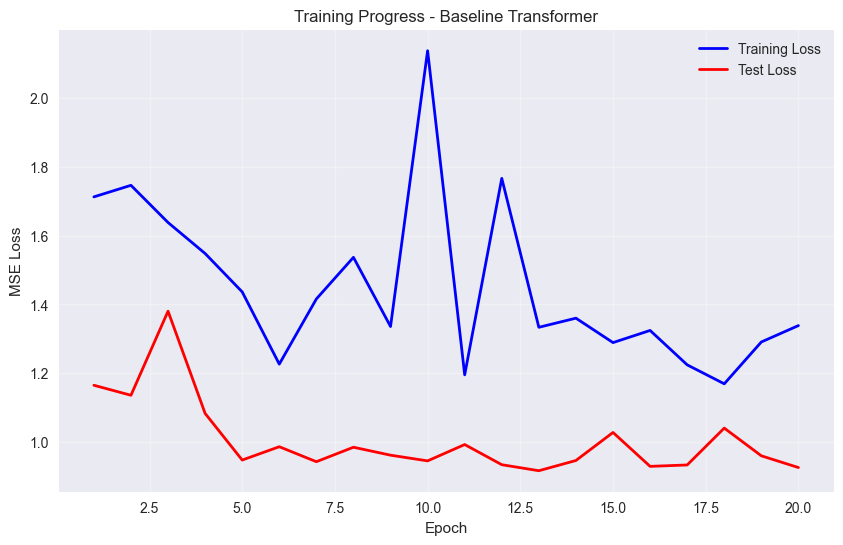

Final training loss: 1.338593
Final test loss: 0.925959


In [6]:
# Plot training progress
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress - Baseline Transformer')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final training loss: {train_losses[-1]:.6f}")
print(f"Final test loss: {test_losses[-1]:.6f}")

## 4. Generate Scenarios and Evaluate

In [7]:
# Load best model for generation
checkpoint = torch.load('../../data/models/baseline_best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Generate scenarios
def generate_scenarios(model, num_scenarios=5, length=100, context_length=32):
    """Generate multiple market scenarios"""
    scenarios = []
    
    with torch.no_grad():
        for i in range(num_scenarios):
            # Use random context from test data
            context_idx = np.random.randint(0, len(test_X) - context_length)
            context = test_X[context_idx:context_idx+1, :context_length, :]  # Shape: (1, context_len, 1)
            
            # Generate continuation
            generated = model.generate(context, length=length, temperature=1.0)
            
            # Extract the generated part (remove context)
            scenario = generated[0, context_length:, 0].numpy()  # Shape: (length,)
            scenarios.append(scenario)
            
            if (i + 1) % 2 == 0:
                print(f"Generated scenario {i + 1}/{num_scenarios}")
    
    return scenarios

print("Generating scenarios...")
generated_scenarios = generate_scenarios(model, num_scenarios=5, length=200)
print(f"Generated {len(generated_scenarios)} scenarios")

Generating scenarios...


Generated scenario 2/5


Generated scenario 4/5


Generated 5 scenarios


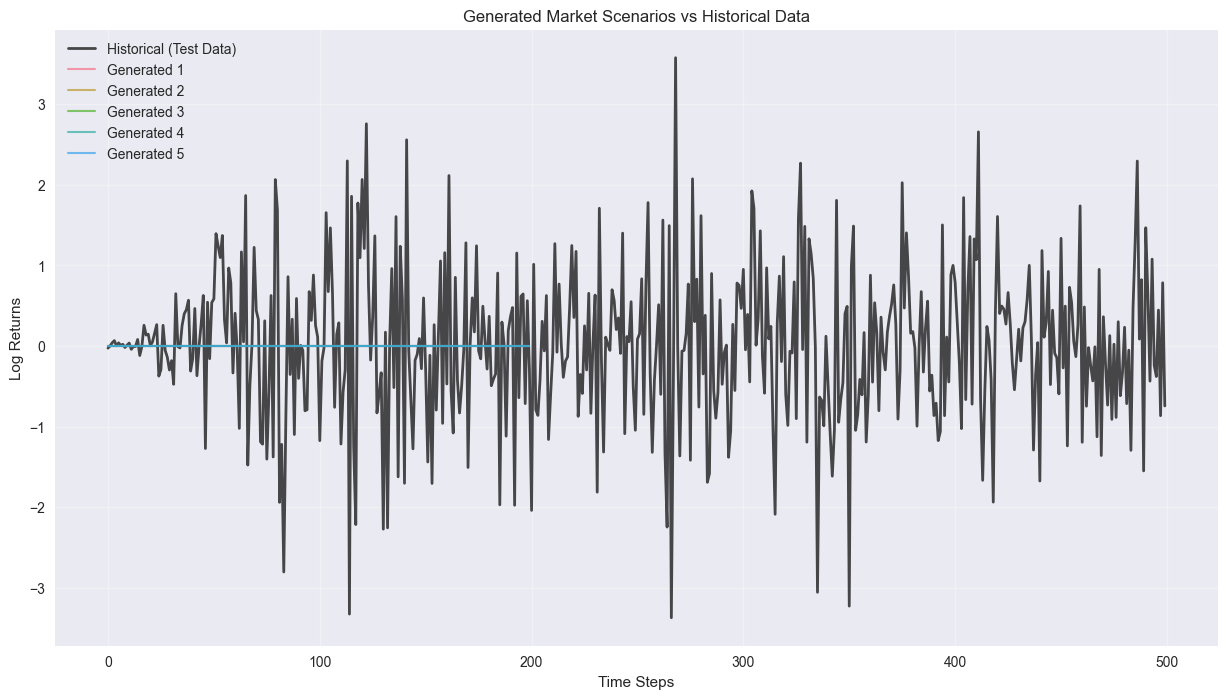

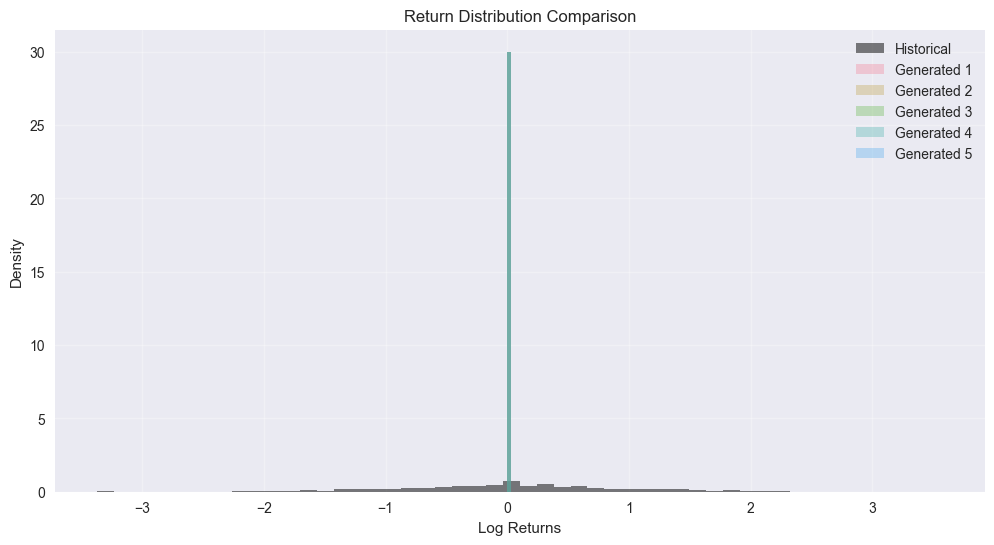

In [ ]:
# Visualize generated scenarios
plt.figure(figsize=(15, 8))

# Plot historical returns for comparison
# Convert to numpy array explicitly to satisfy functions expecting ndarray
from ml.utils import to_numpy_array
historical_returns = to_numpy_array(test_data['log_returns'])[-500:]
plt.plot(historical_returns, alpha=0.7, color='black', linewidth=2, label='Historical (Test Data)')

# Plot generated scenarios
for i, scenario in enumerate(generated_scenarios):
    plt.plot(scenario, alpha=0.7, linewidth=1.5, label=f'Generated {i+1}')

plt.title('Generated Market Scenarios vs Historical Data')
plt.xlabel('Time Steps')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot return distributions
plt.figure(figsize=(12, 6))

plt.hist(historical_returns, bins=50, alpha=0.5, density=True, label='Historical', color='black')

for i, scenario in enumerate(generated_scenarios):
    plt.hist(scenario, bins=30, alpha=0.3, density=True, label=f'Generated {i+1}')

plt.title('Return Distribution Comparison')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Comprehensive Statistical Evaluation

In [ ]:
# Initialize evaluator
from ml.utils import to_numpy_array

evaluator = ScenarioEvaluator()

# Run comprehensive evaluation
print("Running comprehensive evaluation...")
scenario_labels = [f'Baseline_Scenario_{i+1}' for i in range(len(generated_scenarios))]

# Ensure historical_returns is an ndarray
historical_returns = to_numpy_array(historical_returns)

evaluation_results = evaluator.comprehensive_evaluation(
    generated_scenarios, 
    historical_returns, 
    scenario_labels,
)

# Print summary
evaluator.print_evaluation_summary(evaluation_results)

Running comprehensive evaluation...
SCENARIO EVALUATION SUMMARY
Number of scenarios evaluated: 5
Historical data length: 500

STATISTICAL TESTS:
  Mean KS-test p-value: 0.0000
  Scenarios passing KS-test (p≥0.05): 0/5
  Mean ACF similarity score: 0.0000
  Mean volatility similarity score: 0.0168

OVERALL QUALITY SCORE: 0.0056
❌ Primary success criterion not met (KS p-value < 0.05)


In [10]:
# Detailed analysis of each metric
print("\nDETAILED EVALUATION RESULTS:")
print("="*60)

for label, results in evaluation_results['scenarios'].items():
    print(f"\n{label}:")
    print(f"  KS-test p-value: {results['ks_test']['p_value']:.4f}")
    print(f"  ACF similarity: {results['acf_analysis']['acf_similarity_score']:.4f}")
    print(f"  Volatility similarity: {results['volatility_analysis']['volatility_similarity_score']:.4f}")
    
    moments = results['moments']
    print(f"  Mean return: {moments['mean']:.6f}")
    print(f"  Volatility: {moments['std']:.6f}")
    print(f"  Skewness: {moments['skewness']:.4f}")
    print(f"  Kurtosis: {moments['kurtosis']:.4f}")

# Historical data statistics
hist_moments = evaluation_results['historical']['moments']
print(f"\nHistorical Data Statistics:")
print(f"  Mean return: {hist_moments['mean']:.6f}")
print(f"  Volatility: {hist_moments['std']:.6f}")
print(f"  Skewness: {hist_moments['skewness']:.4f}")
print(f"  Kurtosis: {hist_moments['kurtosis']:.4f}")


DETAILED EVALUATION RESULTS:

Baseline_Scenario_1:
  KS-test p-value: 0.0000
  ACF similarity: 0.0000
  Volatility similarity: 0.0168
  Mean return: 0.000000
  Volatility: 0.000000
  Skewness: nan
  Kurtosis: nan

Baseline_Scenario_2:
  KS-test p-value: 0.0000
  ACF similarity: 0.0000
  Volatility similarity: 0.0168
  Mean return: 0.000000
  Volatility: 0.000000
  Skewness: nan
  Kurtosis: nan

Baseline_Scenario_3:
  KS-test p-value: 0.0000
  ACF similarity: 0.0000
  Volatility similarity: 0.0168
  Mean return: 0.000000
  Volatility: 0.000000
  Skewness: nan
  Kurtosis: nan

Baseline_Scenario_4:
  KS-test p-value: 0.0000
  ACF similarity: 0.0000
  Volatility similarity: 0.0168
  Mean return: 0.000000
  Volatility: 0.000000
  Skewness: nan
  Kurtosis: nan

Baseline_Scenario_5:
  KS-test p-value: 0.0000
  ACF similarity: 0.0000
  Volatility similarity: 0.0168
  Mean return: 0.000000
  Volatility: 0.000000
  Skewness: nan
  Kurtosis: nan

Historical Data Statistics:
  Mean return: 0.0179

## 6. Save Baseline Results

In [11]:
# Save evaluation results
import json
from datetime import datetime

# Prepare results for saving (convert numpy arrays to lists)
def prepare_for_json(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: prepare_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [prepare_for_json(item) for item in obj]
    else:
        return obj

results_to_save = {
    'timestamp': datetime.now().isoformat(),
    'model_info': {
        'type': 'baseline_transformer',
        'parameters': model.count_parameters(),
        'architecture': 'LightweightTransformer',
        'sequence_length': sequence_length,
        'batch_size': batch_size,
        'epochs_trained': num_epochs,
        'best_test_loss': best_test_loss
    },
    'training_losses': train_losses,
    'test_losses': test_losses,
    'evaluation_results': prepare_for_json(evaluation_results),
    'generated_scenarios': [scenario.tolist() for scenario in generated_scenarios]
}

# Save to file
os.makedirs('../../data/results', exist_ok=True)
with open('../../data/results/baseline_results.json', 'w') as f:
    json.dump(results_to_save, f, indent=2)

print("Baseline results saved to: ../../data/results/baseline_results.json")

# Save scenarios as CSV for easy export
scenarios_df = pd.DataFrame({
    f'scenario_{i+1}': scenario 
    for i, scenario in enumerate(generated_scenarios)
})
scenarios_df.to_csv('../../data/results/baseline_scenarios.csv', index=False)
print("Scenarios saved to: ../../data/results/baseline_scenarios.csv")

Baseline results saved to: ../../data/results/baseline_results.json
Scenarios saved to: ../../data/results/baseline_scenarios.csv


## 7. Summary and Next Steps

In [12]:
# Final summary
print("BASELINE MODEL TRAINING COMPLETED")
print("="*50)

summary = evaluation_results['summary']

print(f"Model Parameters: {model.count_parameters():,}")
print(f"Training Epochs: {num_epochs}")
print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Best Test Loss: {best_test_loss:.6f}")
print(f"")
print(f"EVALUATION METRICS:")
print(f"  Mean KS-test p-value: {summary['mean_ks_p_value']:.4f}")
print(f"  Scenarios passing KS-test: {summary['pass_ks_test_005']}/{summary['num_scenarios']}")
print(f"  Overall quality score: {summary['overall_quality_score']:.4f}")

# Check success criteria
success = summary['mean_ks_p_value'] >= 0.05
print(f"")
if success:
    print("✅ SUCCESS: Primary criterion met (KS p-value ≥ 0.05)")
else:
    print("⚠️  PARTIAL: Primary criterion not fully met")
    print("   Consider: longer training, different architecture, or data preprocessing")

print(f"")
print("NEXT STEPS:")
print("1. Implement federated learning version")
print("2. Compare FL performance to this baseline")
print("3. Optimize hyperparameters if needed")
print("4. Create demo artifacts with these results")

BASELINE MODEL TRAINING COMPLETED
Model Parameters: 37,777
Training Epochs: 20
Final Training Loss: 1.338593
Best Test Loss: 0.916703

EVALUATION METRICS:
  Mean KS-test p-value: 0.0000
  Scenarios passing KS-test: 0/5
  Overall quality score: 0.0056

⚠️  PARTIAL: Primary criterion not fully met
   Consider: longer training, different architecture, or data preprocessing

NEXT STEPS:
1. Implement federated learning version
2. Compare FL performance to this baseline
3. Optimize hyperparameters if needed
4. Create demo artifacts with these results
